In [1]:
import argparse
from pathlib import Path
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import DataLoader, random_split
import torch
import config
from dataset import FaceLandmarksDataset, get_files
from models import FaceAlignmentModel
%reload_ext autoreload
%autoreload 2
files = get_files(config.TRAIN_FOLDERS)
train_size = int(len(files) * config.TRAIN_VAL_SPLIT)
train_files, val_files = random_split(files, [train_size, len(files) - train_size])

d:\face_alignment_test\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_dataset = FaceLandmarksDataset(train_files, train=True)
val_dataset = FaceLandmarksDataset(val_files, train=False)

d:\face_alignment_test\venv\lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


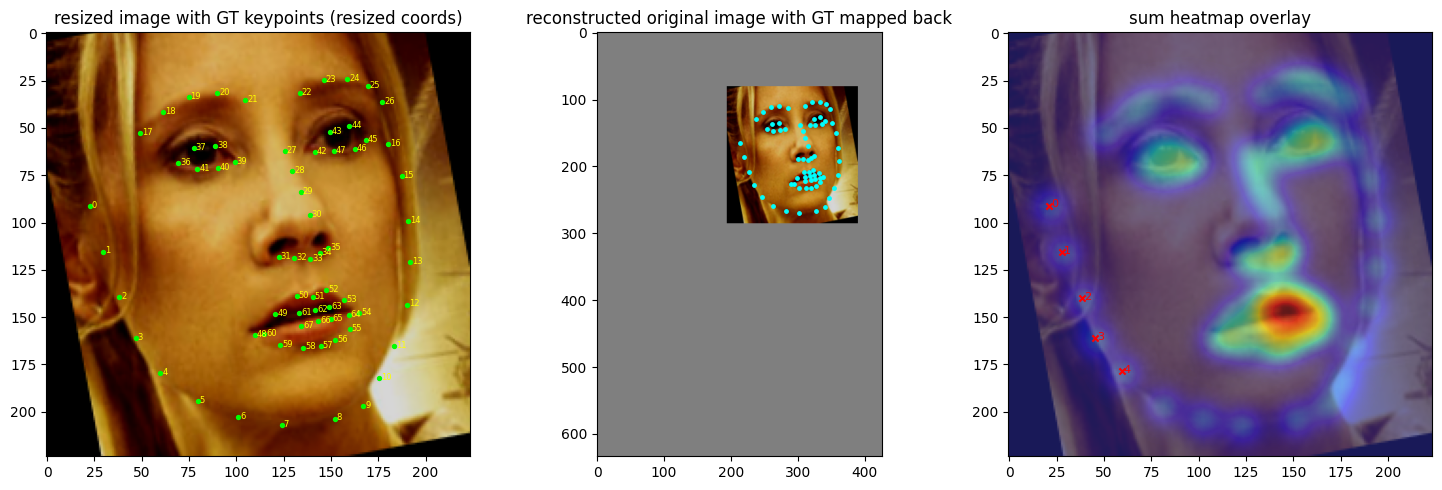

sample 197: mean_px_resized=1.376, n_visible=68


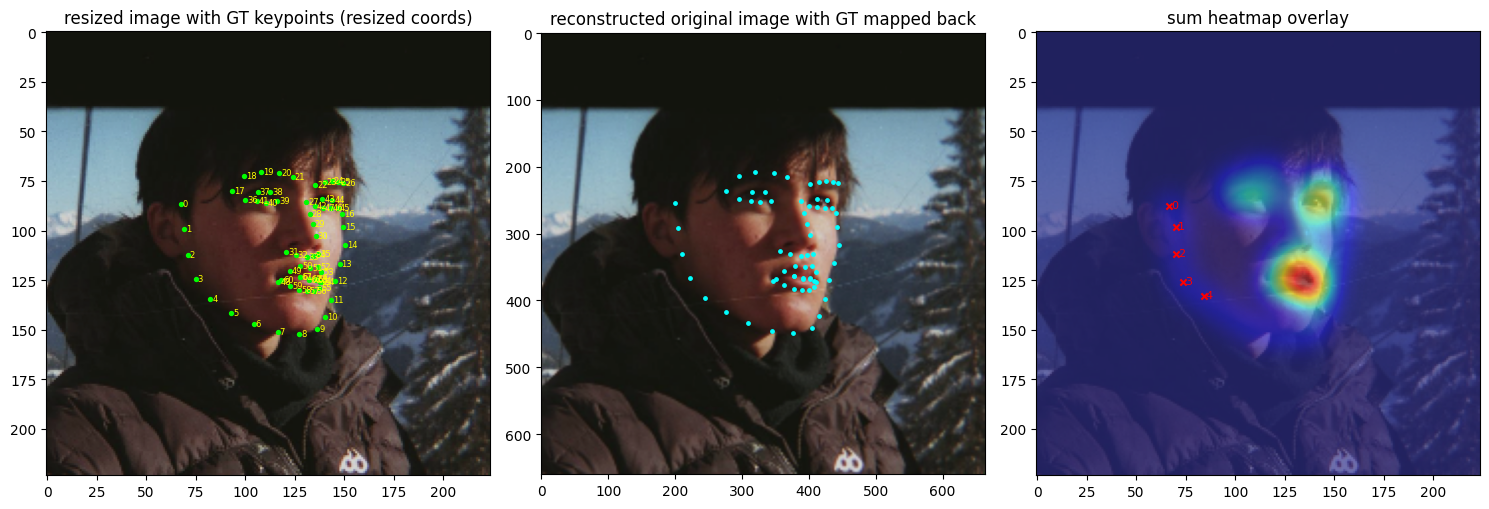

sample 3: mean_px_resized=1.423, n_visible=68


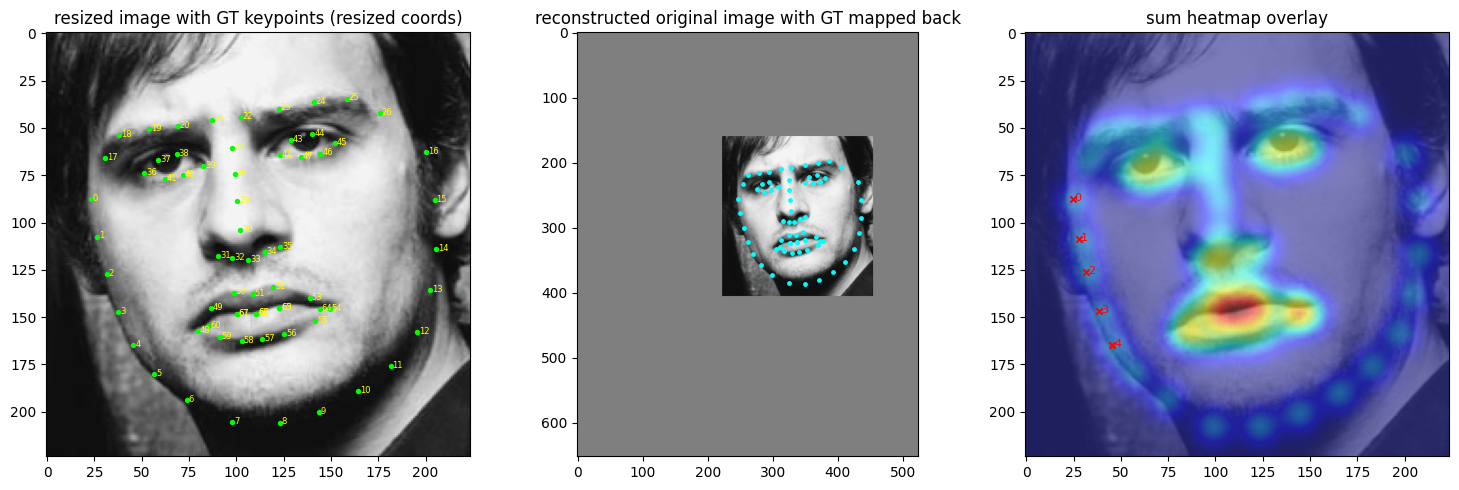

sample 2766: mean_px_resized=1.291, n_visible=68


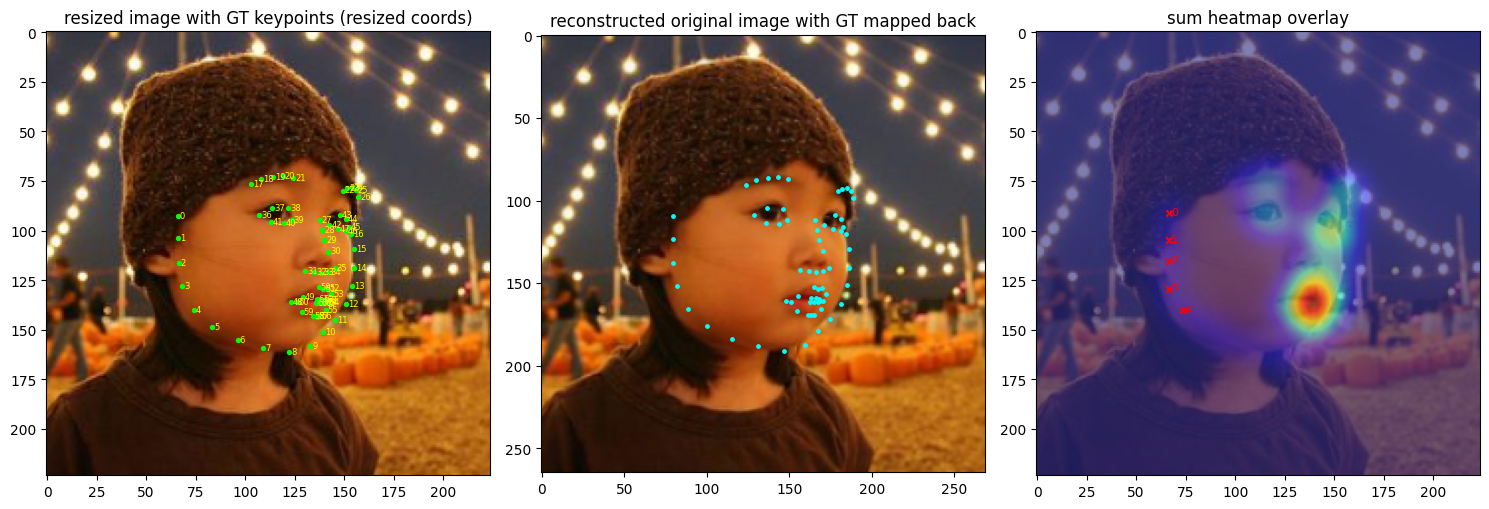

sample 2869: mean_px_resized=1.312, n_visible=68


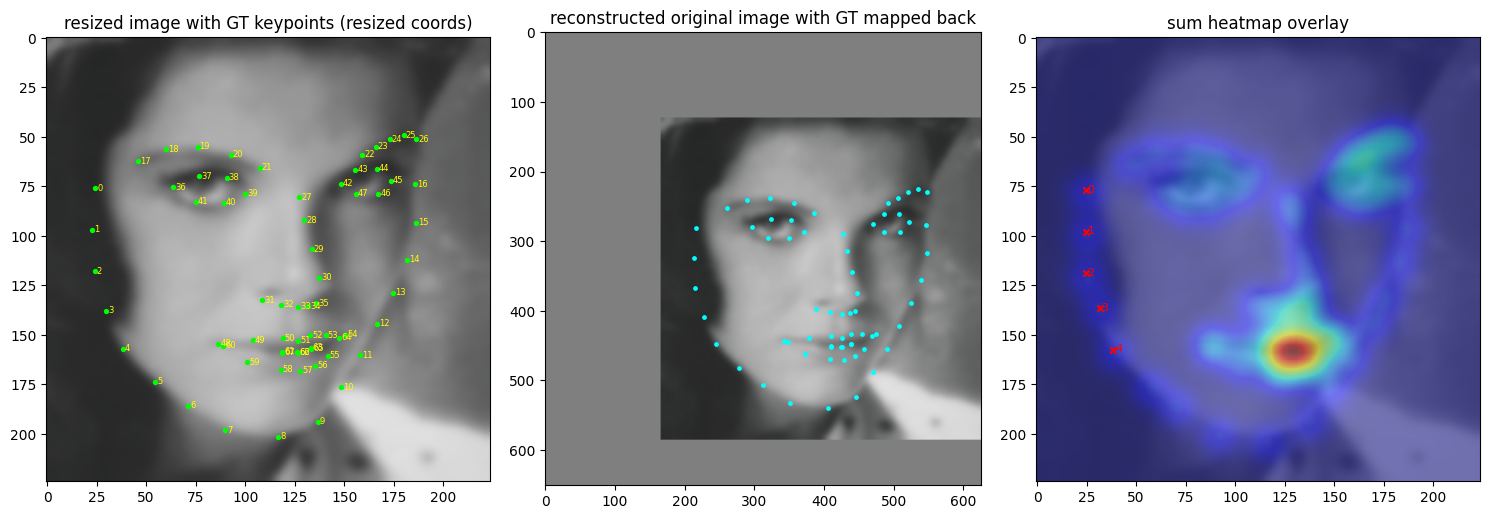

sample 2801: mean_px_resized=1.358, n_visible=68


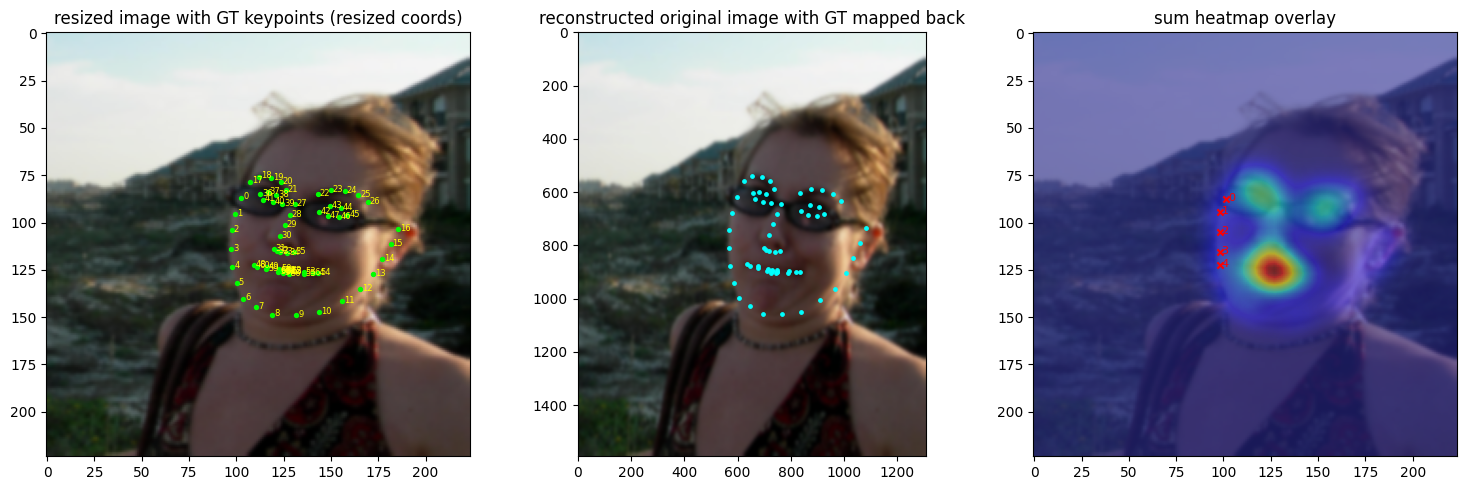

sample 2350: mean_px_resized=1.321, n_visible=68


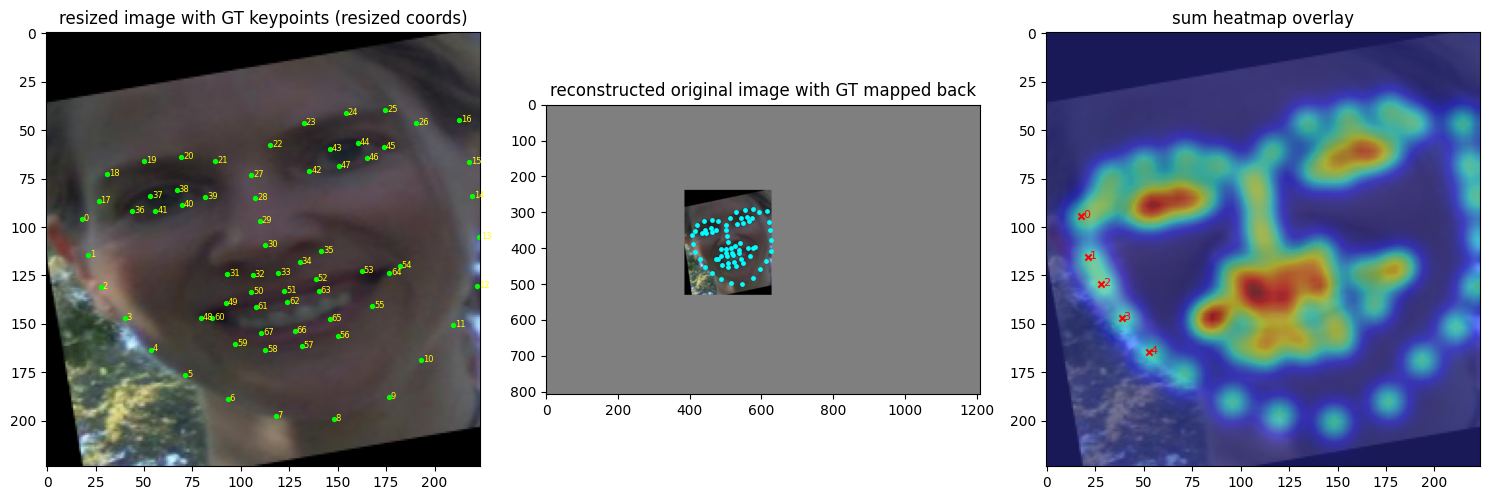

sample 2293: mean_px_resized=1.296, n_visible=68


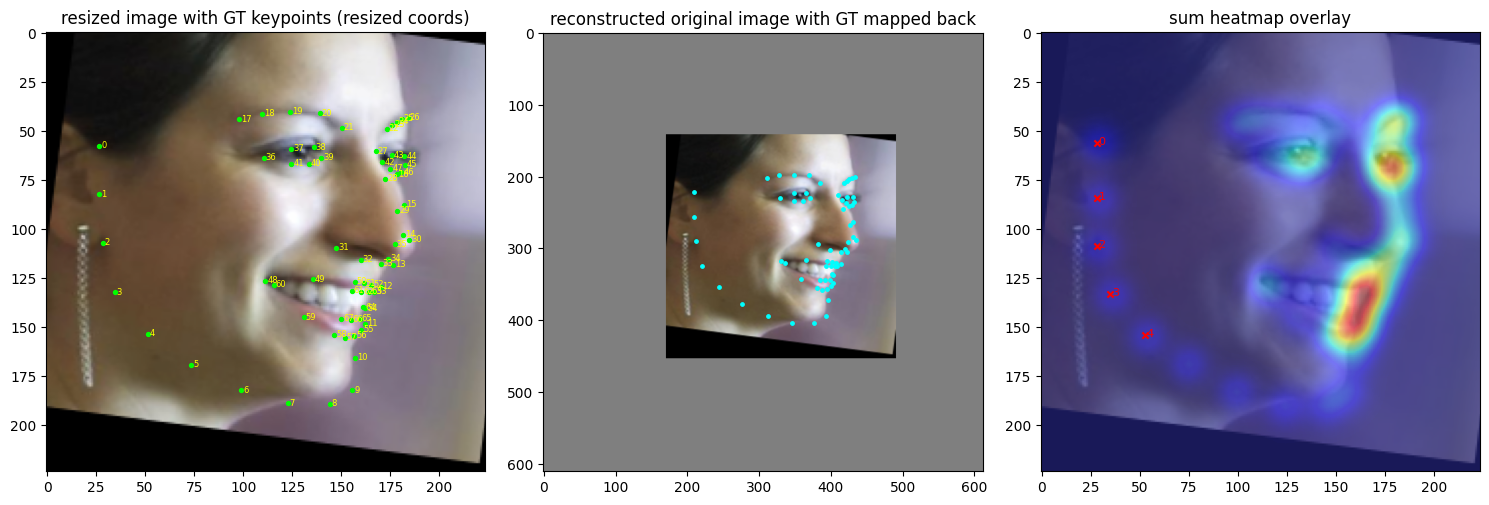

sample 7337: mean_px_resized=1.274, n_visible=68


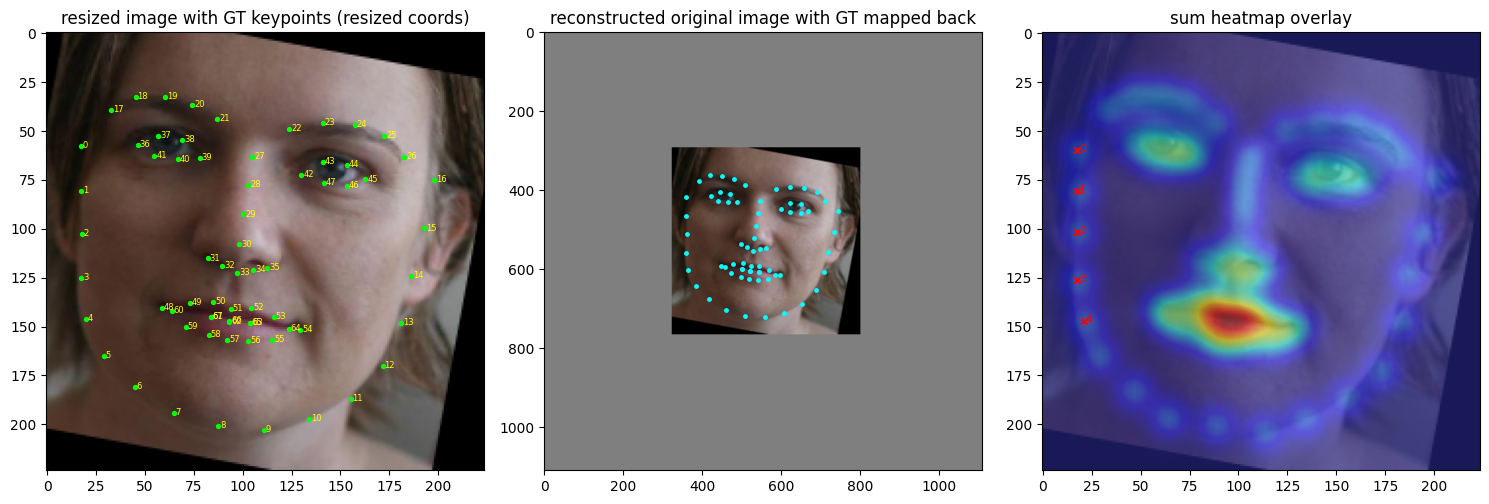

sample 4694: mean_px_resized=1.369, n_visible=68


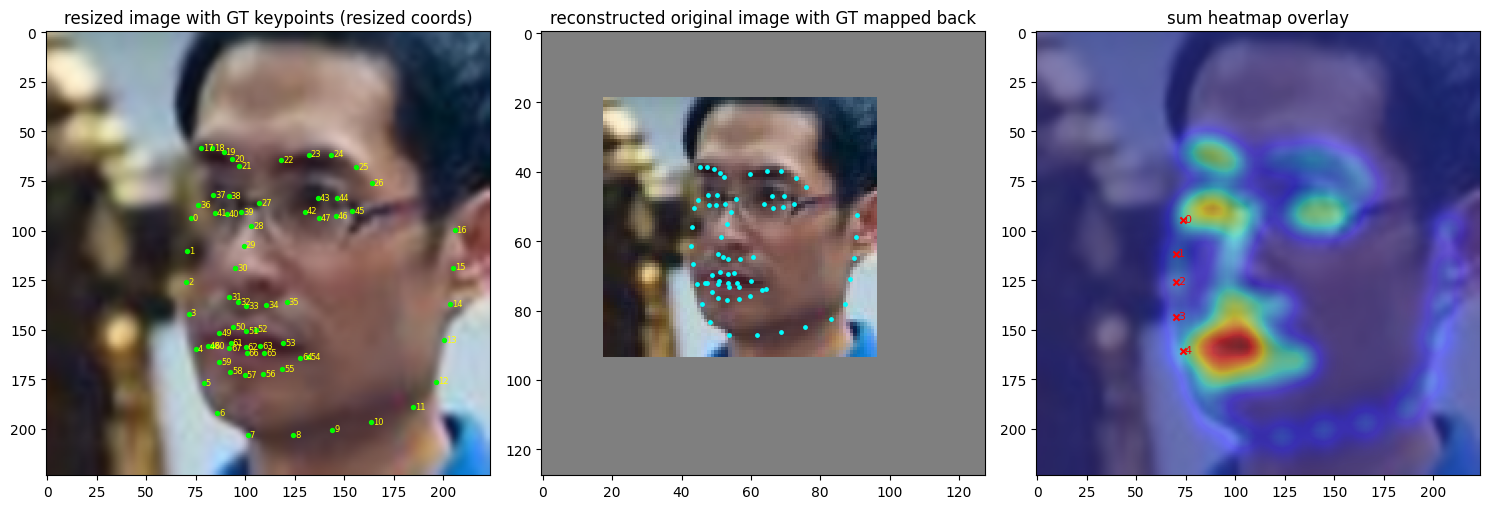

sample 3920: mean_px_resized=1.359, n_visible=68


In [3]:
import numpy as np
import torch
import torch.nn.functional as F

def heatmaps_to_keypoints_argmax(heatmaps):
    """
    heatmaps: numpy (K, H_hm, W_hm) or torch tensor (K,H,W)
    returns: coords (K,2) in heatmap-grid pixels (x, y)
    """
    if isinstance(heatmaps, torch.Tensor):
        heatmaps = heatmaps.detach().cpu().numpy()
    K, H, W = heatmaps.shape
    coords = np.zeros((K, 2), dtype=np.float32)
    for i in range(K):
        idx = heatmaps[i].argmax()
        y = idx // W
        x = idx % W
        coords[i] = np.array([x, y], dtype=np.float32)
    return coords

def heatmaps_to_keypoints_softargmax_tensor(heatmaps_tensor, beta=100.0):
    """
    heatmaps_tensor: torch tensor (B=1,K,H,W) or (K,H,W)
    returns: numpy (K,2) coords in heatmap-grid pixels (x,y)
    Soft-argmax (differentiable); useful for subpixel refinement.
    """
    single = False
    if heatmaps_tensor.ndim == 3:
        heatmaps_tensor = heatmaps_tensor.unsqueeze(0)  # 1,K,H,W
        single = True
    B, K, H, W = heatmaps_tensor.shape
    h = F.softmax(heatmaps_tensor.view(B, K, -1) * beta, dim=-1).view(B, K, H, W)
    xs = torch.linspace(0, W-1, W, device=heatmaps_tensor.device, dtype=heatmaps_tensor.dtype)
    ys = torch.linspace(0, H-1, H, device=heatmaps_tensor.device, dtype=heatmaps_tensor.dtype)
    xs = xs.view(1,1,1,W)
    ys = ys.view(1,1,H,1)
    x = (h * xs).sum(dim=(2,3))  # B, K
    y = (h * ys).sum(dim=(2,3))
    coords = torch.stack([x, y], dim=-1)  # B, K, 2 (x,y)
    coords = coords.cpu().numpy()
    if single:
        return coords[0]
    return coords  # (B,K,2)

def hm_coord_to_resized(coord_hm, img_size_resized, hm_size):
    # coord_hm: (2,) x,y in heatmap pixels
    H_resized, W_resized = img_size_resized
    H_hm, W_hm = hm_size
    x_resized = coord_hm[0] * (W_resized / W_hm)
    y_resized = coord_hm[1] * (H_resized / H_hm)
    return np.array([x_resized, y_resized], dtype=np.float32)

def resized_to_orig(coord_resized, crop_box, scale):
    # crop_box = [x1, y1, x2, y2], scale = [scale_x, scale_y]
    x_orig = coord_resized[0] * scale[0] + crop_box[0]
    y_orig = coord_resized[1] * scale[1] + crop_box[1]
    return np.array([x_orig, y_orig], dtype=np.float32)

import matplotlib.pyplot as plt
import cv2

def visualize_sample(sample, show=True, out_path=None, top_k=5):
    """
    sample: dict from dataset
    expects:
      - image: tensor C,H,W (resized and normalized)
      - keypoints_px: tensor K,2 in resized pixels (or landmarks)
      - keypoints_norm: tensor K,2 in [0,1]
      - heatmaps: tensor K,H_hm,W_hm (or None)
      - crop_box: tensor [x1,y1,x2,y2]
      - scale_unnorm: [orig_h, orig_w] or scale factors — adapt below
      - orig_size / pil image available externally if needed
    """
    img_t = sample['image'].cpu().numpy().transpose(1,2,0)  # H,W,C (normalized)
    # unnormalize for display:
    mean = np.array(getattr(config, "MEAN", [0.485,0.456,0.406]))
    std = np.array(getattr(config, "STD", [0.229,0.224,0.225]))
    img_disp = (img_t * std + mean)
    img_disp = np.clip(img_disp, 0, 1)

    H_resized, W_resized = img_disp.shape[:2]

    kps_px = sample.get('keypoints_px', sample.get('landmarks')).cpu().numpy()  # K,2
    kps_norm = sample.get('keypoints_norm', None)
    if kps_norm is not None:
        kps_norm = kps_norm.cpu().numpy()

    heatmaps = sample.get('heatmaps', None)
    if heatmaps is not None:
        if isinstance(heatmaps, torch.Tensor):
            hm = heatmaps.cpu().numpy()  # K,H_hm,W_hm
        else:
            hm = heatmaps

    crop_box = sample['crop_box'].cpu().numpy()
    scale = sample['scale'].cpu().numpy()

    fig, axs = plt.subplots(1, 3 if heatmaps is not None else 2, figsize=(15,5))

    # 1) resized image + GT keypoints
    ax = axs[0]
    ax.imshow(img_disp)
    ax.set_title("resized image with GT keypoints (resized coords)")
    # plot all keypoints
    valid = (kps_px[:,0] >= 0) & (kps_px[:,1] >= 0)
    ax.scatter(kps_px[valid,0], kps_px[valid,1], s=8, c='lime', marker='o')
    for i, (x,y) in enumerate(kps_px):
        if valid[i]:
            ax.text(x+1, y+1, str(i), color='yellow', fontsize=6)

    # 2) original crop (reconstructed) + mapped GT
    ax2 = axs[1]
    # to reconstruct original crop for display, we need original full image.
    # We'll create a blank canvas and show where crop would sit
    canvas = np.ones((int(sample['orig_size'][0].item()), int(sample['orig_size'][1].item()), 3), dtype=np.float32) * 0.5
    # draw crop region from resized image scaled back to crop size
    crop_w = int((crop_box[2]-crop_box[0]+1))
    crop_h = int((crop_box[3]-crop_box[1]+1))
    # resize img_disp to crop size for visualization
    img_crop_vis = cv2.resize((img_disp*255).astype(np.uint8), (crop_w, crop_h))
    # place into canvas
    x1,y1 = int(crop_box[0]), int(crop_box[1])
    canvas[y1:y1+crop_h, x1:x1+crop_w] = img_crop_vis / 255.0
    ax2.imshow(canvas)
    ax2.set_title("reconstructed original image with GT mapped back")
    # map resized keypoints -> orig and plot
    kps_resized = kps_px.copy()
    # handle invisible:
    for i in range(kps_resized.shape[0]):
        if kps_resized[i,0] < 0:
            continue
        x_res, y_res = kps_resized[i]
        x_orig = x_res * scale[0] + crop_box[0]
        y_orig = y_res * scale[1] + crop_box[1]
        ax2.scatter([x_orig], [y_orig], c='cyan', s=6)
        # optionally annotate indices:
        # ax2.text(x_orig+1, y_orig+1, str(i), color='white', fontsize=6)

    # 3) heatmap overlay for a few keypoints + peaks
    if heatmaps is not None:
        ax3 = axs[2]
        # show sum of heatmaps upsampled to resized size (for visual)
        sum_hm = np.sum(hm, axis=0)  # H_hm, W_hm
        sum_hm_resized = cv2.resize(sum_hm, (W_resized, H_resized))
        ax3.imshow(img_disp, alpha=0.8)
        ax3.imshow(sum_hm_resized, cmap='jet', alpha=0.5)
        ax3.set_title("sum heatmap overlay")
        # draw argmax peaks for first N keypoints
        peaks = heatmaps_to_keypoints_argmax(hm)
        for i in range(min(len(peaks), top_k)):
            px_hm = peaks[i]
            px_res = hm_coord_to_resized(px_hm, (H_resized, W_resized), (hm.shape[1], hm.shape[2]))  # hm shape is (K,H,W): careful
            # note: our helper expects hm shape ordering accordingly
            ax3.scatter(px_res[0], px_res[1], c='red', s=20, marker='x')
            ax3.text(px_res[0]+1, px_res[1]+1, str(i), color='red', fontsize=8)

    plt.tight_layout()
    if out_path:
        plt.savefig(out_path, dpi=150)
    if show:
        plt.show()
    plt.close(fig)

def compute_nme_from_sample(sample):
    """
    Проверка: heatmaps -> argmax -> map back -> compare with original GT
    Возвращает mean NME и per-keypoint errors (in pixels and normalized).
    """
    kps_px = sample['keypoints_px'].cpu().numpy()   # resized pixels (GT)
    heatmaps = sample['heatmaps']
    if heatmaps is None:
        raise RuntimeError("No heatmaps in sample")
    if isinstance(heatmaps, torch.Tensor):
        hm = heatmaps.cpu().numpy()
    else:
        hm = heatmaps

    # get peaks in heatmap grid (x_hm,y_hm)
    peaks_hm = heatmaps_to_keypoints_argmax(hm)  # K,2 (x,y) in hm grid

    # map peaks -> resized
    H_resized, W_resized = sample['image'].shape[1], sample['image'].shape[2]
    H_hm, W_hm = hm.shape[1], hm.shape[2]
    peaks_resized = np.zeros_like(peaks_hm)
    peaks_resized[:,0] = peaks_hm[:,0] * (W_resized / W_hm)
    peaks_resized[:,1] = peaks_hm[:,1] * (H_resized / H_hm)

    # compare only visible GT keypoints (kps_px >=0)
    vis = (kps_px[:,0] >= 0) & (kps_px[:,1] >= 0)
    diffs = np.linalg.norm(peaks_resized[vis] - kps_px[vis], axis=1)  # pixels in resized image
    mean_px = np.mean(diffs) if diffs.size > 0 else 0.0

    # normalized error relative to sqrt(H*W) of face_rect (as in your metric)
    face_rect = sample['face_rect'].cpu().numpy()
    Hf = face_rect[3] - face_rect[1]
    Wf = face_rect[2] - face_rect[0]
    norm = np.sqrt(Hf * Wf) if Hf>0 and Wf>0 else 1.0
    diffs_orig = diffs * ( (sample['scale'][0].item() + sample['scale'][1].item())/2.0 )  # approx map pixels->orig (better map each axis)
    # better: map peaks_resized -> orig using scale + crop_box and compute distance in original pixels to GT original
    # but we can estimate:
    mean_norm = mean_px / max(1e-6, np.sqrt(H_resized * W_resized))  # just check smallness
    return {
        "mean_px_resized": mean_px,
        "mean_norm_resized": mean_norm,
        "per_point_px": diffs,
        "n_visible": int(np.sum(vis))
    }

from random import randint

def quick_check_dataset(ds, n=10):
    for i in range(n):
        idx = randint(0, len(ds)-1)
        sample = ds[idx]
        visualize_sample(sample, show=True)
        stats = compute_nme_from_sample(sample)
        print(f"sample {idx}: mean_px_resized={stats['mean_px_resized']:.3f}, n_visible={stats['n_visible']}")

quick_check_dataset(train_dataset, n=10)

In [4]:
from train import train

name = "lol"
model_type = "efficientnet_b0"
loss_type = "wing"
head_type = "regression"

train(name, model_type, loss_type, head_type)

Unexpected keys (bn2.num_batches_tracked, bn2.bias, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | backbone  | EfficientNetFeatures | 3.6 M  | train
1 | pool      | AdaptiveAvgPool2d    | 0      | train
2 | regress

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

d:\face_alignment_test\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


d:\face_alignment_test\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1:   2%|▏         | 1/59 [01:05<1:03:28,  0.02it/s, v_num=1, train_loss_step=0.473, val_loss=0.299, train_loss_epoch=0.812]


Detected KeyboardInterrupt, attempting graceful shutdown ...


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "d:\face_alignment_test\venv\lib\site-packages\pytorch_lightning\trainer\call.py", line 49, in _call_and_handle_interrupt
    return trainer_fn(*args, **kwargs)
  File "d:\face_alignment_test\venv\lib\site-packages\pytorch_lightning\trainer\trainer.py", line 598, in _fit_impl
    self._run(model, ckpt_path=ckpt_path)
  File "d:\face_alignment_test\venv\lib\site-packages\pytorch_lightning\trainer\trainer.py", line 1011, in _run
    results = self._run_stage()
  File "d:\face_alignment_test\venv\lib\site-packages\pytorch_lightning\trainer\trainer.py", line 1055, in _run_stage
    self.fit_loop.run()
  File "d:\face_alignment_test\venv\lib\site-packages\pytorch_lightning\loops\fit_loop.py", line 216, in run
    self.advance()
  File "d:\face_alignment_test\venv\lib\site-packages\pytorch_lightning\loops\fit_loop.py", line 458, in advance
    self.epoch_loop.run(self._data_fetcher)
  File "d:\face_alignment_test\venv\lib\site-packages\pytorch_lightn